In [ ]:
!pip install keras=='2.3.1'
!pip install tensorflow=='2.2.0'

     |████████████████████████████████| 378kB 2.8MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 3.0MB 2.8MB/s 
     |████████████████████████████████| 460kB 23.6MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
from keras.preprocessing import image
import numpy as np

Using TensorFlow backend.


In [ ]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/daisies.zip

--2020-08-12 12:17:30--  https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/daisies.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/daisies.zip [following]
--2020-08-12 12:17:32--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/daisies.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8652765 (8.3M) [application/zip]
Saving to: ‘daisies.zip’

daisies.zip         100%[===================>]   8.25M  23.2MB/s    in 0.4s    

2020-08-12 12:17:32 (23.2 MB/s) - ‘daisies.zip’ saved [8652765/8652765]



In [ ]:
!unzip daisies.zip

Archive:  daisies.zip
  inflating: d01.jpeg                
  inflating: d02.jpeg                
  inflating: d03.jpeg                
  inflating: d04.jpeg                
  inflating: d05.jpeg                
  inflating: d06.jpeg                
  inflating: d07.jpeg                
  inflating: d08.jpeg                
  inflating: d09.jpeg                
  inflating: d10.jpeg                
  inflating: d11.jpeg                
  inflating: d12.jpeg                
  inflating: d13.jpeg                
  inflating: d14.jpeg                
  inflating: d15.jpeg                
  inflating: g01.jpeg                
  inflating: g01b.jpeg               
  inflating: g01b.jpg                
  inflating: g02.jpeg                
  inflating: g02b.jpg                
  inflating: g02c.jpeg               
  inflating: g03.jpeg                
  inflating: g04.jpeg                
  inflating: g05.jpeg                
  inflating: g06.jpeg                
  inflating: g07.jpeg       

In [ ]:
# read in images:

from keras.preprocessing import image
import numpy as np
import os

daisies = []
files = os.listdir('.')
for file in files:
    if file == ".config": continue
    if file == "sample_data": continue
    if file == "images": continue
    if file == "daisies.zip": continue
    img = image.load_img(file) #, color_mode="grayscale")
#    img = image.load_img(file)
    img = img.resize((36,36))
    img_arr = image.img_to_array(img)
    img_arr = img_arr.flatten()
    img_arr = img_arr.reshape(36,36,3)
    daisies += [img_arr]

In [ ]:
len(daisies)

133

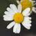

In [ ]:
image.array_to_img(daisies[0])

In [ ]:
daisies[0].shape

(36, 36, 3)

In [15]:
!mkdir images

In [16]:
# from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 36
        self.img_cols = 36
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        quartersize = 9 # 16 # 7
        model.add(Dense(128 * quartersize * quartersize, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((quartersize, quartersize, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

#        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

#        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
#        (X_train, _), (_, _) = mnist.load_data()
        X_train = np.array(daisies)
#        print(X_train.shape)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
#        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
#            print(gen_imgs.shape)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/daisies_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
#    dcgan.train(epochs=4001, batch_size=32, save_interval=50) # 4001
    dcgan.train(epochs=1501, batch_size=32, save_interval=50)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.117915, acc.: 48.44%] [G loss: 0.479413]
1 [D loss: 0.756668, acc.: 60.94%] [G loss: 1.039914]
2 [D loss: 0.478589, acc.: 79.69%] [G loss: 1.616556]
3 [D loss: 0.401753, acc.: 82.81%] [G loss: 1.684300]
4 [D loss: 0.336206, acc.: 85.94%] [G loss: 1.422016]
5 [D loss: 0.229862, acc.: 93.75%] [G loss: 1.138463]
6 [D loss: 0.154343, acc.: 96.88%] [G loss: 0.684567]
7 [D loss: 0.273311, acc.: 89.06%] [G loss: 0.497332]
8 [D loss: 0.205961, acc.: 93.75%] [G loss: 0.440267]
9 [D loss: 0.176581, acc.: 95.31%] [G loss: 0.581023]
10 [D loss: 0.411253, acc.: 82.81%] [G loss: 0.364652]
11 [D loss: 0.280920, acc.: 89.06%] [G loss: 0.953546]
12 [D loss: 0.344561, acc.: 85.94%] [G loss: 0.837288]
13 [D loss: 0.592023, acc.: 68.75%] [G loss: 1.093358]
14 [D loss: 0.273400, acc.: 92.19%] [G loss: 0.965723]
15 [D loss: 0.383523, acc.: 84.38%] [G loss: 1.038579]
16 [D loss: 0.342489, acc.: 89.06%] [G loss: 1.260875]
17 [D loss: 0.272312, acc.: 92.19%] [G loss: 1.588028]
18 [D loss: 0.269028

In [18]:
from keras.preprocessing import image

for e in range(30):
  print(e*50)
  img = image.load_img("images/daisies_"+str(e*50)+".png")
  display(img)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
!ls 

cw1.jpg   d15.jpeg     g10f.jpeg  g22.jpeg   g32v.jpeg	g47c.jpeg  g56.jpeg
cw2.jpg   daisies.zip  g10g.jpeg  g23.jpeg   g33.jpeg	g47d.jpeg  g57.jpeg
cw3.jpg   g01b.jpeg    g10h.jpeg  g24.jpeg   g34.jpeg	g47.jpeg   g58b.jpeg
cw4.jpg   g01b.jpg     g10i.jpeg  g24v.jpeg  g35.jpeg	g48b.jpeg  g58c.jpeg
cw5.jpg   g01.jpeg     g10.jpeg   g25b.jpeg  g36.jpeg	g48c.jpeg  g58.jpeg
cw6.jpg   g02b.jpg     g11.jpeg   g25.jpeg   g37.jpeg	g48.jpeg   g59.jpeg
d01.jpeg  g02c.jpeg    g12.jpeg   g26.jpeg   g38.jpeg	g49.jpeg   g60b.jpeg
d02.jpeg  g02.jpeg     g13.jpeg   g27.jpeg   g39.jpeg	g50.jpeg   g60.jpeg
d03.jpeg  g03.jpeg     g14.jpeg   g28b.jpeg  g40.jpeg	g51.jpeg   g61.jpeg
d04.jpeg  g04.jpeg     g15.jpeg   g28c.jpeg  g41.jpeg	g52.jpeg   g62b.jpeg
d05.jpeg  g05.jpeg     g16b.jpeg  g28.jpeg   g42.jpeg	g53b.jpeg  g62c.jpeg
d06.jpeg  g06.jpeg     g16c.jpeg  g29b.jpeg  g43b.jpeg	g53c.jpeg  g62d.jpeg
d07.jpeg  g07.jpeg     g16.jpeg   g29c.jpeg  g43.jpeg	g53d.jpeg  g62.jpeg
d08.jpeg  g08.jpeg     g17.jpe